# DCR analysis

## Processing of waveforms

**GOAL**
- count all events
- make plot amplitude VS time to discriminate between 1 phe signals ("real counts" and afterpulses) and 2 phe signals (crosstalks)
- evaluate % of afterpulses and crosstalks wrt total

Notes: time axis has a physical minimum due to width of waveform

**Procedure**
- csv files of waveforms and timestamps combined
- csv files, sliced into single waveforms
- find minima (absolute and relative), plot them, count them (count single points of absolute minimum) and save their timestamps and amplitude
- from amplitude value you understand if a peak is noise (crosstalk, afterpulse)
- get amplitudes and timestamps of each minimum

*Afterpulse*: happens tipically at 0.5 $\mu$s after a real signal, and has an amplitude almost equal to 1 phe; threshold for considering an event an afterpulse of the event before is 6 $\mu$s.  
*Crosstalk*: single peak of amplitude 2 phe

## Goals, tips and tricks

You have to find an automated way to find the "good" absolute minimum.
How?

- [x] Extrapolate baseline: evaluate it by using only pre-trigger amplitudes.
- [x] Discriminate if two peaks have a distance between each other that is too small (is less than the width of the window)
- [x] **Raise an error or quarantine the snippet if you have a number of minima that is too big**
    - implemented coding "bad" and "good" for clean_minima that are in wf with too many minima or with saturated, -inf data
- [ ] **Evaluate the derivative of the ramp up of a peak**
- [ ] Dark count rate is number of total events / total time --> **calculate total time**


Options to follow to throw away noisy signals:

1. Throw away all noise: if the waveform is not good (has more than one minimum that goes over the threshold) throw it away completely; have to count all the waveforms that are thrown and estimate fraction of total events
2. Check on saturated events: must be true to have points over the threshold and also have some number of points (like, 10) in a very narrow range of values (all equal)

Final goals:

1. Create 2D plot with time deltas (x) and amplitude (y): time deltas are the differences between timestamps of any two successive "good" peaks

### Code from Guarise

Already commented by Guarise, I already reviewed it.

---

### My code structure

Starting from code from Guarise, polishing and dividing in different functions

**Header**
```python

def read_wf(file_name):
    """
    Basic read function with automatic timestamp or wf detection from file_name;
    also constructs both dataframes
    """
    if file name contains 'time.csv' then do...
    if else file_name contains wf.csv then do...
    else NameError
        raise

def analysis_wf(timestamp_table, wf_table, wf_datapoints, threshold, distance, inplace=True):
    """
    This function finds all the minima in the waveforms and selects the "good ones" based on
    - minim amplitude = threshold (mV)
    - number of data in between two consecutive absolute minima = distance (adim, integer)
    Option inplace tells if the function modifies the original wf dataframe by adding a column with good minima.
    if inplace == True: return nothing
    if inplace == False: return copy of original dataframe with new column of good minima
    """
    
def plot_wf(timestamp_table, wf_table, wf_datapoints, loop=True, show=False, save=False,): #wf_table must contain the "good minima" column
    """
    This function plots the waveform by its data, in a amplitude(mV) vs timestamp plot.
    Automatically detects if the dataframe contains one or more waveforms and if loop==True loops on all the wf,
    otherwise only plots the first one (good for debuggind/building phases)
    Options:
    - show scatter only (wf) [doesn't require "good minima" column]
    - show minima
    This function returns nothing.
    """

def plot_dcr(minimum_table, hist=True):
    """
    Only needs a dataframe minimum_table with the list of the minima and the related timestamps.
    Plots an amplitude (mV) vs delta_t (ns) graph, useful to detect noise source.
    Option hist=True plots an histogram subplot under the 2D plot, representing the integral in the vertical
    direction of the ampli vs dt plot.
    """
```
        

In [1]:
import os
import re
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema

In [ ]:
# from dcr_functions import *

## Read

In [2]:
def read_wf(fname):
    """Basic read function with automatic timestamp or wf file type detection.
    
    Parameters
    ----------
    - fname: relative path of the file with respect to the current working directory
    
    Returns
    -------
    Pandas' dataframe of the data provided.
    
    """
    
    
    # If the file provided is a timestamp file, follow this routine:
    # - open the file
    # - make a dataframe with the timestamps; the header is as default in line 0
    # - timestamps are relative and provide the time interval with respect to the previous trigger:
    #    make them absolute by computing the cumulative of each timestamp with cumsum method of pd
    if re.search("time.csv", fname): 
        timestamp_file_name = fname
        timestamp_path = os.path.join(os.getcwd(),timestamp_file_name)
        timestamp_table = pd.read_csv(timestamp_path) 
            # if file is not found, FileNotFoundError is raised automatically
        timestamp_table.rename(columns = {'X: (s)': 'Event', 'Y: (Hits)':'Timestamp'}, inplace = True)
        N_of_events = len(timestamp_table) # = 1000
        timestamp_table["Timestamp"] = timestamp_table["Timestamp"].cumsum(axis=0)
        
        return timestamp_table
        
    # If the file provided is a waveform file, follow this routine:
    # - open the file
    # - detect the number of datapoints in each waveform, wf_datapoints = 6250
    # - detect end of header ("TIME") and make a dataframe with the wf data
    elif re.search("wf.csv", fname):
        wf_file_name = fname
        wf_path = os.path.join(os.getcwd(),wf_file_name)
        wf_table = pd.DataFrame()
        
        with open(wf_file_name, 'r') as file_wf:
                # if file is not found, FileNotFoundError is raised automatically
            lines = file_wf.readlines()
            for line_counter, line in enumerate(lines):
                if line.startswith("Record Length"): wf_datapoints = int(line.split(',')[-1]) # = 6250
                if line.startswith("Horizontal"): time_unit = str(line.split(',')[-1]).rstrip("\n") # = s\n
                if line.startswith("Vertical"): ampl_unit = str(line.split(',')[-1]).rstrip("\n") # = V\n
                if line.startswith("FastFrame"): wf_events = int(line.split(',')[-1]) # = 1000
                    # To implement when both files are required by the function
                    # if wf_events != N_of_events: break
                if line.startswith("TIME"):
                    wf_table = pd.read_csv(wf_path, header = line_counter-1)
                    break
        
        meta = {
            'path' : wf_path,
            'n events' : wf_events,
            'data points' : wf_datapoints,
            'time units' : time_unit,
            'ampl units' : ampl_unit,}
                    
        return wf_table, meta
    
    else:
        raise NameError("Please provide the path to a waveform or timestamp comma-separated file (.csv).")

## Analysis

In [3]:
def analysis(timestamp_table, wf_table, meta, custom_n_events=1000, time_adjust=True,
             threshold=0.006, distance=50, many_minima=6250,
             plot=False, save_plot=False):
    """Function to analyze waveform data and locate clean signal peaks.
    
    This function finds all the minima in each waveform (wf) and selects the "good ones" (clean_min) based on
    threshold (V) and distance (#). The resulting dataframe has a column "code" that indicates if
    a clean_min belongs to a good or bad wf: bad wfs are the ones containing a number of relative minima
    bigger than many_minima or that contain -inf saturated data. Notice that the "good" or "bad" coding
    makes sense for discriminating between equally clean_min only: discrimination is not provided for
    minima that are not considered to be "good" signal.
   
   ------
   Input:
   - timestamp_table: pandas.DataFrame
       Dataframe with timestamps
   - wf_table: pandas.DataFrame
       Dataframe with waveforms in list mode
   - meta: dict
       Dictionary with metadata of wf_table
   - custom_n_events: int, default 1000
       Number of events to analyze (starts from the first waveform in any case)
   - time_adjust: bool, default True
       If True, adds timestamps from timestamp_table to wf_table. May be kept
       True for the first time the analysis is run on the dataset, switch
       to False afterwards.
   - threshold: float, default 0.006 [V]
       Minimum value of signal to discriminate it from noise, in units of V
   - distance: int, default 50
       Number of data in between two consecutive absolute minima
   - many_minima: int, default 6250 (# data in single waveform)
       Provide a number of minimum minima to be found to turn on or off a warning 
       that is raised if in the waveform there are more than that number of minima.
       Also provides additional column in dataframe with code "bad_wf" for
       waveforms that satisfy the above condition.
   - plot: bool, default False
       If True, plot the scatterplot of the waveforms with the relative minima in a
       recursive way
   
   --------
   Returns:
   - copy of original dataframe with added columns of minima (total) and clean minima (based
       on threshold and distance)
    
    """
    
    ############################# UPDATES TO MAKE ####################################
    # - [x] RETURNS wf_table complete with all clean minima
    # - [x] MUST HAVE inplace=True/False option: like this you're rewriting wf_table every time
    # - [x] must decide if you want or not to be able to plot relative minima
    # - [x] discard saturated waveforms: must have a lot of almost-same-amplitude points
    #     this is already done since dense minima would be discarded from clean by default 
    # - [x] set as bad wf containing -inf data
    # - [x] identify waveforms with too many minima
    #     - [x] count # of discarded waveforms and get fraction wrt total 
    # - [x] Add tag "bad" along with minimum list, to be added as column in final, total df
    # - [x] clean_min must contain effective signal amplitude (difference wrt baseline), not absolute
    # - [x] metadata update with number of analysis already performed
    ##################################################################################
    
    start_time = time.time()
    
    N_of_events = custom_n_events        
    wf_datapoints = len(wf_table)/1000
    
    copy = wf_table.copy()
    general_clean_ampl = []
    general_clean_min = []
    general_bad = []
    time_list = []
    N_bad_wf = 0
        
    for n in range(N_of_events):
        print("Analysis of event number " + str(n+1), end='\r') #'\r' overwrites output
        event_name = 'Event_' + str(n) + '.png'
        
        if time_adjust == True:
            copy["TIME"].loc[wf_datapoints*n: (wf_datapoints*(n+1))-1] += timestamp_table.at[n,"Timestamp"]            
        
        single_wf = copy.loc[wf_datapoints*n: (wf_datapoints*(n+1))-1].copy()
        minimum_list = argrelextrema(single_wf.CH1.values, np.less_equal, order = distance)[0]
        baseline = np.polyfit(single_wf["TIME"].iloc[0:250], single_wf["CH1"].iloc[0:250],0)[0]
        time_list.append(single_wf.TIME.max()-single_wf.TIME.min())

        gap = threshold
        clean_minimum_list = []
        previous_index     = minimum_list[0]
        
        for index in minimum_list:
            if (baseline - single_wf["CH1"].iat[index] > gap) and (index > previous_index + distance):
                clean_minimum_list.append(index)
                general_clean_ampl.append(baseline - single_wf["CH1"].iat[index])
                previous_index = index
                        
        inf_counts = 0
        inf_counts = len(single_wf[single_wf.CH1==-np.inf])
        if inf_counts > 0:
            N_bad_wf += 1
        
        wf_index = (n*wf_datapoints)
        for index in clean_minimum_list:
            general_clean_min.append(index + wf_index)
            
            if len(minimum_list) > many_minima or inf_counts > 0: # implement or for wf containing -inf data 
                general_bad.append(index + wf_index)
        
        # Plotting control (inside loop)
        if plot==True:
            single_wf.loc[:,'min'] = single_wf.iloc[minimum_list]['CH1']
            single_wf.loc[:,'clean_min'] = single_wf.iloc[clean_minimum_list]['CH1']
            plt.plot(single_wf["TIME"], single_wf['CH1'], linestyle="-", linewidth=1)
            plt.scatter(single_wf["TIME"], single_wf['min'], color="darkred")
            plt.scatter(single_wf["TIME"], single_wf['clean_min'], color="green")
            plt.axhline(baseline, c='b')
            plt.show()
            
        if save_plot==True:
            figure_path = os.path.join(os.path.join(os.getcwd(),'grafici'), event_name)
            plt.savefig(figure_path)
            plt.close()
    
    # Metadata update
    total_time = sum(time_list)
    meta['total acquis time'] = total_time
    meta['n clean minima'] = len(general_clean_min)-len(general_bad)
    meta['n bad minima'] = len(general_bad)
    meta['DCR'] = meta["n clean minima"]/total_time
    
    # Printed output
    print('\nAnalysis completed.')
    print('Number of clean minima found: ', len(general_clean_min)-len(general_bad))
    print('Fraction of waveforms with too many minima or -inf data ("bad_wf") on total: %s%%' % format(N_bad_wf/custom_n_events*100,".2f"))
    print('Total acquisition time: {0:0.3e} s'.format(total_time))
    print('Estimated DCR: {0:0.3e} Hz'.format(meta["n clean minima"]/total_time))
        
    # Return control
    clean_ampl = pd.DataFrame(general_clean_ampl, index=general_clean_min, columns=['ampl_min'])
    if many_minima < 6250 or len(general_bad) > 0:
        bad_list = ['bad_wf' for item in general_bad]
        bad = pd.DataFrame(bad_list, index=general_bad, columns=['code'])
        
    copy.loc[:,'clean_min'] = copy.iloc[general_clean_min]['CH1']
    copy = copy.join(clean_ampl)
    copy = copy.join(bad)
    copy.code.fillna(value='good', inplace=True)
    copy['wfID'] = np.array(range(len(copy))) // 6250
    copy.set_index('wfID', append=True, inplace=True)
    print("Process completed in %s s." % (format(time.time()-start_time,".2f")))
    return copy, meta

In [10]:
def analysis_delta_t(analyzed_wf, meta,
                    noise_list=['primary dark counts', 'delayed crosstalk', 'crosstalk', 'afterpulses'],
                    crosstalk_thr=10e-3, delayed_cross_thr=6e-6,
                    ):
    """Function to polish the dataframe returned from the analysis function and discriminate between noise.
    
    """

    mins = analyzed_wf.dropna() # drops all rows with NaNs, that are found in clean_min only
    mins = mins.loc[mins.code=='good']
    mins['TIME'] = mins['TIME'].diff(periods=1)
    mins = mins.iloc[1:,[0,-2]]
    mins.rename(columns={'TIME':'Delta T (s)','ampl_min':'Amplitude (V)'}, inplace = True)
    
    def noise_discrimination(df, crosstalk_thr=10e-3, delayed_cross_thr=6e-6):
            primary_mean = df.groupby(by=[df['Amplitude (V)'] < crosstalk_thr]).get_group(True)['Amplitude (V)'].mean()
            primary_std = df.groupby(by=[df['Amplitude (V)'] < crosstalk_thr]).get_group(True)['Amplitude (V)'].std()
            df['Noise'] = (
                np.where(
                    df['Amplitude (V)'] > crosstalk_thr , 'crosstalk',
                    np.where(df['Delta T (s)'] < delayed_cross_thr, 'delayed crosstalk', 'primary dark counts')))
            df.loc[df['Amplitude (V)'] < (primary_mean-3*primary_std)]['Noise'].apply(lambda x : 'afterpulses')
            return df
    
    mins = noise_discrimination(mins)
    
    return mins, meta

## Plot scatter

## Plot 2D

In [37]:
def plot_2d(data, sns_palette='deep', title='2D plot',
            show=True, save=False, save_path='./Amplitude_vs_dt.', save_extension='pdf',
            **kwargs,):
    """2D plot with amplitude (V) vs time delta (s) scatterplot and kernel density estimation.
    
    """

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Preprocessing
    mins = data
    n_mins = len(mins)
    noise_list_red = mins.groupby('Noise').count().index.values
    
    deep_cmap = sns.color_palette(sns_palette, 10)
    palette = sns.color_palette([deep_cmap[i] for i in range(len(noise_list_red))])
    palette_dict = {noise_list_red[i] : palette[i] for i in range(len(noise_list_red))}
    mean_dict = {key : mins.groupby('Noise').mean().loc[key]['Delta T (s)'] for key in noise_list_red}
    percent_dict = {key : mins.groupby('Noise').count().loc[key].values[0]/n_mins*100 for key in noise_list_red}
    
    # Plotting
    f, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=False)
    ax1 = axs[0]
    ax2 = axs[1]
    
    sns.scatterplot(data=mins, x="Delta T (s)", y="Amplitude (V)", hue="Noise", ax=ax1,
                    hue_order=[key for key in noise_list_red],
                    alpha=0.7, legend=False, palette=sns_palette)
    sns.kdeplot(data=mins, x="Delta T (s)", hue="Noise", ax=ax2,
                hue_order=[key for key in noise_list_red],
                multiple="stack", fill=True, log_scale=True, common_norm=True,
                edgecolor='white', alpha=0.7, palette=sns_palette,
                legend=False)
    
    ax1.set_title(title, fontsize=14)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('Density (%)')
    
    legend_scatter = [Line2D([0], [0], marker='o', color='w', label=key,
                              markerfacecolor=palette_dict[key], markersize=8) for key in palette_dict.keys()]
    
    legend_kde = [Line2D([0], [0], marker='o', color='w', label=key+' ({0:0.1f}%)'.format(percent_dict[key]),
                              markerfacecolor=palette_dict[key], markersize=8) for key in palette_dict.keys()]
    
    ax1.legend(handles=legend_scatter, loc='upper left')
    ax2.legend(handles=legend_kde, loc='upper left') #bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    # Output control
    if show==True:
        plt.show()
    else:
        plt.close()
    
    if save==True:
        f.savefig(save_path+save_extension)


# Blocks for testing

In [6]:
wf_table, meta = read_wf(".\\Data\\DCR\\HPKR00030_2cicli_OV3_wf.csv")

In [229]:
meta

{'path': 'C:\\Users\\MARTINA\\Desktop\\OOPROJECT\\pyproj\\branch_dcr\\.\\Data\\DCR\\HPKR00030_2cicli_OV3_wf.csv',
 'n events': 1000,
 'data points': 6250,
 'time units': 's',
 'ampl units': 'V'}

In [7]:
time_table = read_wf(".\\Data\\DCR\\HPKR00030_2cicli_OV3_time.csv")

In [15]:
wf_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250000 entries, 0 to 6249999
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   TIME    float64
 1   CH1     float64
dtypes: float64(2)
memory usage: 95.4 MB


In [16]:
wf_table

,TIME,CH1
0,-9.994500e-08,-0.000809
1,-9.978500e-08,-0.000809
2,-9.962500e-08,-0.000809
3,-9.946500e-08,-0.000809
4,-9.930500e-08,-0.000809
...,...,...
6249995,8.993500e-07,-0.000496
6249996,8.995100e-07,-0.000496
6249997,8.996700e-07,-0.000496
6249998,8.998300e-07,-0.000496


In [17]:
time_table.head()

,Event,Timestamp
0,0,0.000000
1,1,0.015416
2,2,0.015771
3,3,0.020706
4,4,0.030981


In [8]:
wf, meta = analysis(time_table, wf_table, meta, plot=False, many_minima=500, time_adjust=True)

Analysis of event number 1000
Analysis completed.
Number of clean minima found:  1073
Fraction of waveforms with too many minima or -inf data ("bad_wf") on total: 1.10%
Total acquisition time: 9.998e-04 s
Estimated DCR: 1.073e+06 Hz
Process completed in 32.63 s.


In [11]:
mins, meta = analysis_delta_t(wf, meta)

In [237]:
mins

,,Delta T (s),Amplitude (V),Noise
,wfID,,,
6974,1,0.015416,0.007200,primary dark counts
13221,2,0.000355,0.007230,primary dark counts
19473,3,0.004935,0.007261,primary dark counts
25721,4,0.010274,0.007147,primary dark counts
31971,5,0.004953,0.006906,primary dark counts
...,...,...,...,...
6219475,995,0.017280,0.007405,primary dark counts
6225725,996,0.017200,0.007479,primary dark counts
6231979,997,0.017403,0.007661,primary dark counts


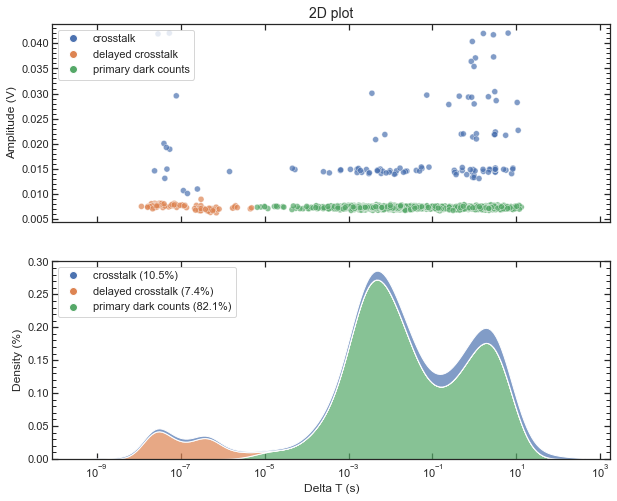

In [38]:
plot_2d(mins, show=True, save=True, save_extension='pdf')

In [28]:
noise_list_red = mins.groupby('Noise').count().index.values
deep_cmap = sns.color_palette('deep', 10)
palette = sns.color_palette([deep_cmap[i] for i in range(len(noise_list_red))])

zipped = [zip(noise_list_red, palette)]
palette_dict = {noise_list_red[i] : palette[i] for i in range(len(noise_list_red))}
for key in palette_dict.keys():
    print(str(palette_dict[key]))

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
